Using device: cuda
Loaded 1000 examples (500 slang, 500 non-slang)

--- Probing BART-large-MNLI ---


Layers for BART-large-MNLI:   0%|          | 0/12 [00:00<?, ?it/s]


--- Probing BERT-base-MNLI ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/630 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Layers for BERT-base-MNLI:   0%|          | 0/12 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]


--- Probing RoBERTa-large-MNLI ---


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Layers for RoBERTa-large-MNLI:   0%|          | 0/24 [00:00<?, ?it/s]


--- Probing DeBERTa-v3-large ---


tokenizer_config.json:   0%|          | 0.00/395 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/18.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/870M [00:00<?, ?B/s]

Layers for DeBERTa-v3-large:   0%|          | 0/24 [00:00<?, ?it/s]

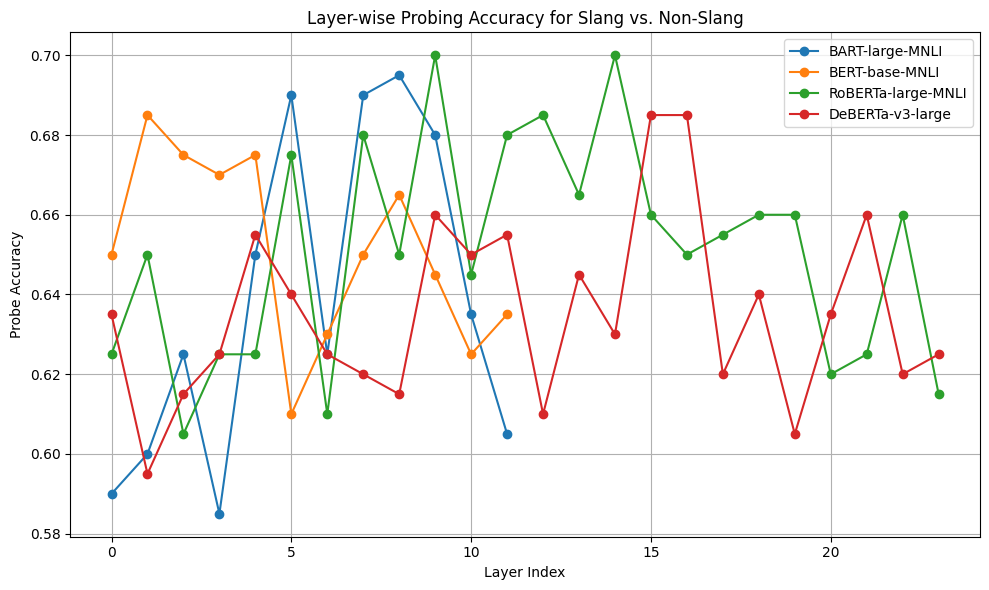

In [3]:
# Colab Notebook: Layerwise Classifier Probing for Slang Detection

# =============================================================================
# 1. Install dependencies
# =============================================================================
!pip install -q transformers scikit-learn pandas torch tqdm matplotlib

# =============================================================================
# 2. Imports and device setup
# =============================================================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# =============================================================================
# 3. Data loading and preparation
# =============================================================================
def load_and_prepare_data(max_samples_per_class=500):
    df_slang = pd.read_csv('/content/slang_OpenSub_filtered.tsv', sep='\t', dtype=str)
    df_nonslang = pd.read_csv('/content/slang_OpenSub_negatives_filtered.tsv', sep='\t', dtype=str)

    df_slang = df_slang.dropna(subset=['SENTENCE'])
    df_slang['label'] = 1

    df_nonslang = df_nonslang.dropna(subset=['SENTENCE'])
    df_nonslang['label'] = 0

    n = min(len(df_slang), len(df_nonslang), max_samples_per_class)
    df_s = df_slang.sample(n=n, random_state=42)
    df_n = df_nonslang.sample(n=n, random_state=42)

    df = pd.concat([df_s, df_n], ignore_index=True).sample(frac=1, random_state=42)
    texts = df['SENTENCE'].tolist()
    labels = df['label'].astype(int).tolist()
    return texts, labels

texts, labels = load_and_prepare_data(max_samples_per_class=500)
print(f"Loaded {len(texts)} examples ({sum(labels)} slang, {len(labels)-sum(labels)} non-slang)")

# =============================================================================
# 4. Function to get CLS embeddings from a specific layer (batched)
# =============================================================================
def get_layer_cls_embeddings(model, tokenizer, sentences, layer_idx, device, batch_size=32):
    all_embeds = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(sentences), batch_size):
            batch_sents = sentences[i:i+batch_size]
            inputs = tokenizer(batch_sents, return_tensors='pt', padding=True,
                               truncation=True, max_length=128).to(device)
            outputs = model(**inputs, output_hidden_states=True)

            # Choose hidden states attribute
            if hasattr(outputs, 'hidden_states') and outputs.hidden_states is not None:
                hidden_states = outputs.hidden_states
            elif hasattr(outputs, 'encoder_hidden_states') and outputs.encoder_hidden_states is not None:
                hidden_states = outputs.encoder_hidden_states
            else:
                raise ValueError("No hidden states returned by model")

            # layer_idx+1 because hidden_states[0] is embeddings
            layer_hidden = hidden_states[layer_idx+1]
            # CLS token at position 0
            cls_batch = layer_hidden[:, 0, :].cpu().numpy()
            all_embeds.append(cls_batch)

            # Free GPU memory for this batch
            del inputs, outputs, hidden_states, layer_hidden
            torch.cuda.empty_cache()

    return np.vstack(all_embeds)

# =============================================================================
# 5. Main probing loop over models and layers
# =============================================================================
models = {
    "BART-large-MNLI":      "facebook/bart-large-mnli",
    "BERT-base-MNLI":      "textattack/bert-base-uncased-MNLI",
    "RoBERTa-large-MNLI":  "roberta-large-mnli",
    "DeBERTa-v3-large":    "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"
}

results = {}
for name, model_id in models.items():
    print(f"\n--- Probing {name} ---")
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModel.from_pretrained(model_id, output_hidden_states=True).to(device)

    n_layers = model.config.num_hidden_layers
    layer_accuracies = []

    for layer in tqdm(range(n_layers), desc=f"Layers for {name}"):
        # Extract CLS embeddings in mini-batches to avoid OOM
        X = get_layer_cls_embeddings(model, tokenizer, texts, layer, device, batch_size=32)
        y = np.array(labels)

        # Standardize & split
        X_scaled = StandardScaler().fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42
        )

        # Train & evaluate probe
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        acc = accuracy_score(y_test, preds)
        layer_accuracies.append(acc)

    results[name] = layer_accuracies

# =============================================================================
# 6. Plotting the probing accuracies by layer
# =============================================================================
plt.figure(figsize=(10, 6))
for name, accs in results.items():
    plt.plot(range(len(accs)), accs, marker='o', label=name)

plt.xlabel('Layer Index')
plt.ylabel('Probe Accuracy')
plt.title('Layer-wise Probing Accuracy for Slang vs. Non-Slang')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


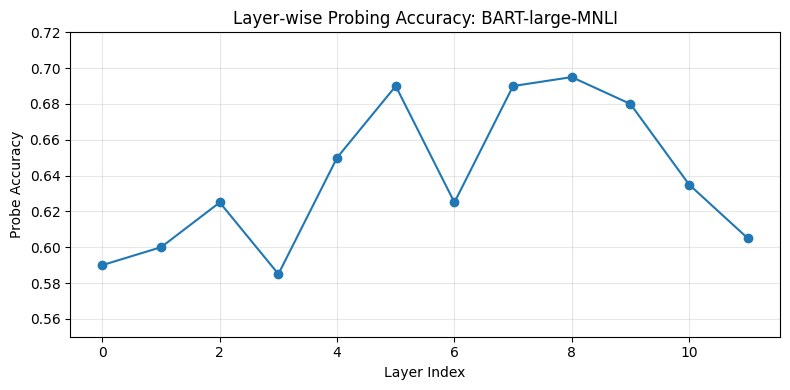

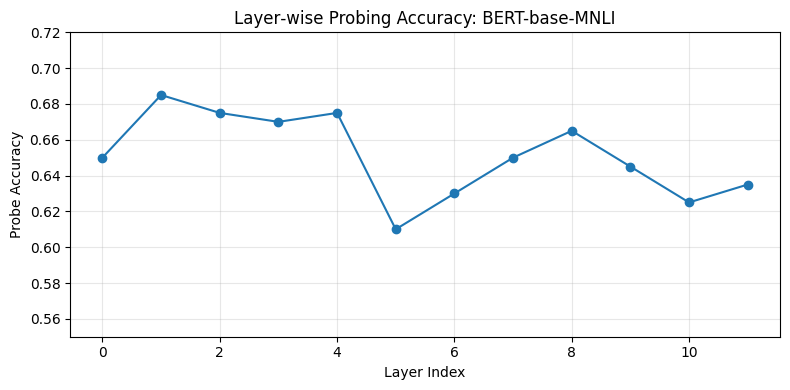

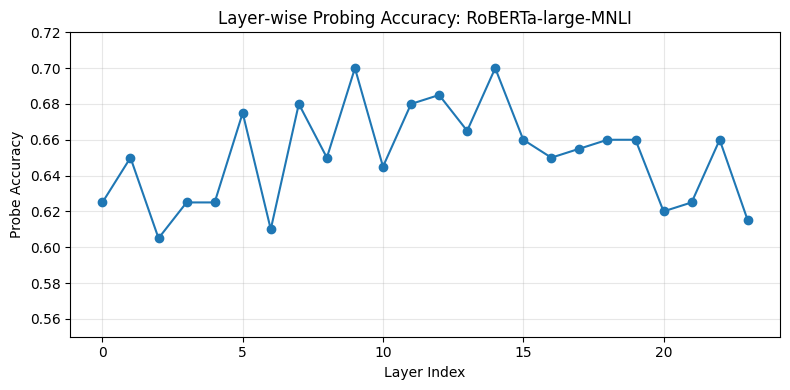

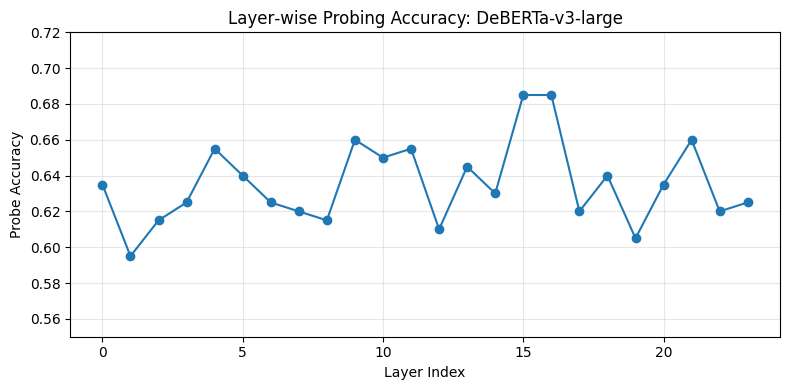

In [4]:
# -------------------------------------------------------------------
# 7. Plot each model on its own figure
# -------------------------------------------------------------------
for name, accs in results.items():
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(accs)), accs, marker='o')
    plt.title(f'Layer‑wise Probing Accuracy: {name}')
    plt.xlabel('Layer Index')
    plt.ylabel('Probe Accuracy')
    plt.ylim(0.55, 0.72)         # fix y‑range for easy comparison
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
